# ¿Que más se podría hacer?

- Test con data augmentation y la LSTM
- Usar los tokenizadores usados en los transformers para ver como funcionan
- TSNE de embeddings y analizar si hay interpretación
- Probar con otras encimas o proteinas
- Usar los embeddings entrenados para analizar resultados de proteinas o encimas con menos data
- Entrenar una red neuronal con los features (fingerprints por ejemplo) y comparar los resultados con los embeddings


# Tome cualquiera de estas propuestas o alguna suya y desarrolle

In [1]:
%load_ext autoreload
%autoreload 2

# Modelo LSTM con generador, embedings de smiles y data-augmentation

In [2]:
import pandas as pd
import numpy as np
from datagen import smiles_dict, smiles_to_seq

2023-09-03 00:04:48.276284: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-03 00:04:48.279650: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-03 00:04:48.360027: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-03 00:04:48.361429: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-03 00:04:49.760679: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

### smiles_dict

In [3]:
len(smiles_dict)

42

smiles_dict nos da un tokenizador para simplificar el problema. Puede ver como se construyó en la notebook **deep_chem**.
Si al momento de correr el modelo con este diccionario encuentra problemas de key_error, puede agregar los faltantes al diccionario

Mirar dentro de **datagen.py** como se usa este diccionario con la función **smiles_to_seq** para tokenizar. El código es muy sencillo

In [4]:
print(smiles_dict)

{'#': 1, '(': 2, ')': 3, '+': 4, '-': 5, '/': 6, '1': 7, '2': 8, '3': 9, '4': 10, '5': 11, '6': 12, '7': 13, '8': 14, '=': 15, 'C': 16, 'F': 17, 'H': 18, 'I': 19, 'N': 20, 'O': 21, 'P': 22, 'S': 23, '[': 24, '\\': 25, ']': 26, '_': 27, 'c': 28, 'Cl': 29, 'Br': 30, 'n': 31, 'o': 32, 's': 33, '@': 34, '.': 35, 'a': 36, 'B': 37, 'e': 38, 'i': 39, '9': 40, '10': 41, '11': 42}


# Carga de los datos

In [5]:
df = pd.read_csv('data/acetylcholinesterase_02_bioactivity_data_preprocessed.csv')

In [6]:
max_len_idx = df['canonical_smiles'].apply(len).argmax()
min_len_idx = df['canonical_smiles'].apply(len).argmin()
max_sequence_len = len(df['canonical_smiles'].iloc[max_len_idx]) + 20

In [7]:
df.head()

,molecule_chembl_id,canonical_smiles,standard_value,standard_value_norm,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,750.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,100.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,50000.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,300.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,800.0,6.096910


In [8]:
X = df['canonical_smiles'].values
y = df['pIC50'].values

# Data augmentation:

https://arxiv.org/pdf/1703.07076.pdf

https://github.com/EBjerrum/molvecgen

https://github.com/Ebjerrum/SMILES-enumeration

En la publicación de arriba se describe una técnica de aumentación de datos para los smiles. Leerla si es de su interes (Opcional)

En el módulo **dataug.py**, tomando como referencia los repositorios arriba citados se implementó la aumentación de datos

In [9]:
seq = 'CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1'

from dataaug import SmilesEnumerator
sme = SmilesEnumerator()
for i in range(10):
    print(sme.randomize_smiles('CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1'))

c1c(COc2cccc(-n3c(=O)oc(OCC)n3)c2)cccc1
c1(OCC)oc(=O)n(-c2cccc(OCc3ccccc3)c2)n1
c1cc(COc2cc(-n3c(=O)oc(OCC)n3)ccc2)ccc1
c1c(OCc2ccccc2)cc(-n2nc(OCC)oc2=O)cc1
O=c1oc(OCC)nn1-c1cccc(OCc2ccccc2)c1
c1(-n2c(=O)oc(OCC)n2)cccc(OCc2ccccc2)c1
O=c1n(-c2cc(OCc3ccccc3)ccc2)nc(OCC)o1
C(Oc1cc(-n2nc(OCC)oc2=O)ccc1)c1ccccc1
c1(COc2cccc(-n3nc(OCC)oc3=O)c2)ccccc1
c1ccccc1COc1cc(-n2c(=O)oc(OCC)n2)ccc1


In [10]:
from dataaug import SmilesEnumerator
sme = SmilesEnumerator()
for i in range(10):
    print(sme.randomize_smiles('CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1'))
    

c1cc(-n2nc(OCC)oc2=O)cc(OCc2ccccc2)c1
O(CC)c1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1
CCOc1oc(=O)n(-c2cccc(OCc3ccccc3)c2)n1
c1(OCc2ccccc2)cc(-n2nc(OCC)oc2=O)ccc1
c1cc(OCc2ccccc2)cc(-n2c(=O)oc(OCC)n2)c1
O(c1cccc(-n2nc(OCC)oc2=O)c1)Cc1ccccc1
c1cccc(COc2cc(-n3nc(OCC)oc3=O)ccc2)c1
CCOc1oc(=O)n(-c2cc(OCc3ccccc3)ccc2)n1
n1(-c2cc(OCc3ccccc3)ccc2)nc(OCC)oc1=O
c1ccc(COc2cccc(-n3nc(OCC)oc3=O)c2)cc1


# DataGenerator

Construir un generador al que se le pase al instanciarlo:
- X: smiles (formula química)
- y: pIC50
- batch_size
- max_sequence_len (int): La máxima longitud de las secuencias (para hacer el padding)
- data_augmentation (boolean): si quiero hacer o no data-augmentation. 
- shuffle (boolean)

Guardarlo en el módulo **datagen.py** con el nombre de la clase **DataGenerator**

Notar que el módulo **datagen.py** ya tiene una estructura para completar

### Importamos el módulo y lo probamos

In [11]:
from datagen import DataGenerator

In [12]:
dgen = DataGenerator(X, y, max_sequence_len, batch_size=32)

In [13]:
len(dgen) * dgen.batch_size

6176

In [14]:
for i, (X_b, y_b) in enumerate(dgen):
    print(f'{i}\r', end='')

In [15]:
X_b

array([[28,  7, 28, ...,  0,  0,  0],
       [21,  2, 24, ...,  0,  0,  0],
       [20,  7,  2, ...,  0,  0,  0],
       ...,
       [16,  2, 20, ...,  0,  0,  0],
       [31,  7, 31, ...,  0,  0,  0],
       [16,  7, 16, ...,  0,  0,  0]])

In [16]:
y_b.shape

(13,)

# Split

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
X_train.shape

(4925,)

In [20]:
X_train = X_train[:4500]
y_train = y_train[:4500]

In [21]:
len(X_train), len(y_train), len(X_test)

(4500, 4500, 1232)

In [22]:
X_train

array(['COc1cc(/C=C/c2ccc3ccccc3[n+]2C)ccc1N1CCOCC1.[I-]',
       'CCCCCCCNC(=O)Oc1ccc2c(c1)C1(C)CCN(CC)C2C1',
       'c1ccc2c(COc3nn(CCN4CCCC4)c4ccccc34)cccc2c1', ...,
       'Cl.Nc1c2c(nc3ccc(F)cc13)CCC2',
       'CCN(CC)CCCCCOc1ccc(C(=O)/C=C/c2ccccc2)cc1',
       'COc1ccccc1/C=C1\\CN(C(=O)C[C@H]2C[C@H]3CCCN3[C@]23C(=O)Nc2ccccc23)C/C(=C\\c2ccccc2OC)C1=O'],
      dtype=object)

In [23]:
dgen_train = DataGenerator(X_train, y_train, seq_length=max_sequence_len, batch_size=64, data_augmentation=True)
dgen_test = DataGenerator(X_test, y_test, seq_length=max_sequence_len, batch_size=64, data_augmentation=False)

In [24]:
dgen_train

In [25]:
for i, (X_b, y_b) in enumerate(dgen_test):
    print(f'{i}\r', end='')

# Network Model

In [26]:
# Métrica
from tensorflow.keras import backend as K
def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, Dense, BatchNormalization, Activation, LSTM
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop  # Import RMSprop optimizer
from tensorflow.keras.metrics import RootMeanSquaredError  # Import RMSE metric
from tensorflow.keras.backend import square, mean  # Import backend functions

# Build the sequential model
model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=42 + 1, output_dim=256, input_length=204))  # Use seq_length here

# Bidirectional LSTM layer with L2 regularization
model.add(Bidirectional(LSTM(100, return_sequences=False, kernel_regularizer=l2(0.01))))

# Dense layer with L2 regularization
model.add(Dense(125, kernel_regularizer=l2(0.01)))

# Batch normalization layer
model.add(BatchNormalization())

# Activation layer
model.add(Activation('relu'))

# Output dense layer
model.add(Dense(1))

# Print the model summary
model.summary()

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# RMSE metric function
def RMSE(y_true, y_pred):
    return tf.sqrt(mean(square(y_pred - y_true)))

# Compile the model with RMSE metric
model.compile(optimizer=RMSprop(learning_rate=0.001, clipvalue=0.1), loss='mse', metrics=[R2,RMSE])

# Instantiate the DataGenerator
dgen_train = DataGenerator(X_train, y_train, seq_length=204, batch_size=64, data_augmentation=True)
dgen_test = DataGenerator(X_test, y_test, seq_length=204, batch_size=64, data_augmentation=True)

history = model.fit(dgen_train, epochs=150, validation_data=dgen_test, callbacks=[lr_scheduler, early_stopping])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 204, 256)          11008     
                                                                 
 bidirectional (Bidirection  (None, 200)               285600    
 al)                                                             
                                                                 
 dense (Dense)               (None, 125)               25125     
                                                                 
 batch_normalization (Batch  (None, 125)               500       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 125)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

In [35]:
X_test_eval = []
y_t_eval = []
for X_t, y_t in dgen_test:
    X_test_eval = X_test_eval + [list(t) for t in X_t]
    y_t_eval = y_t_eval + list(y_t)
X_test_eval = np.array(X_test_eval)
y_test = np.array(y_t_eval)

In [36]:
X_test_eval.shape, y_test.shape

((1232, 204), (1232,))

In [37]:
y_pred = model.predict(X_test_eval)

39/39 [==============================] - 1s 37ms/step


# Score

In [38]:
r2 = 1 - ((y_test - y_pred.reshape(-1)) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()

In [39]:
r2

0.49714720632183196

In [40]:
filename = 'models/other_tests.h5'
model.save(filename)

/home/nando/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Evaluación

<function matplotlib.pyplot.show(close=None, block=None)>

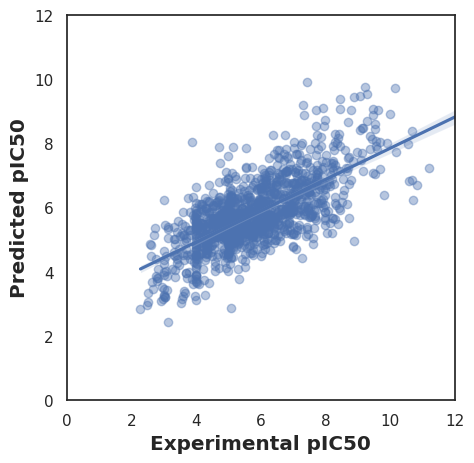

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show